**Ramin Fakhimi** \\
PhD student at ISE department of Lehigh University


In [ ]:
# Install qiskit package
!pip install qiskit

from IPython.display import clear_output
clear_output()

This is an implementation of HHL algorithm for solving 4 by 4 linear systems. 


The quantum circuit is proposed by Cao et. al. \\
https://arxiv.org/pdf/1110.2232v2.pdf

In [ ]:
# Import libraries
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import SwapGate, RYGate, QFT

import numpy as np
from numpy import linalg as LA

from copy import deepcopy

%matplotlib inline
qiskit.__qiskit_version__

{'qiskit': None,
 'qiskit-aer': '0.5.2',
 'qiskit-aqua': '0.7.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-terra': '0.14.2'}

In [ ]:
# Check the hermitian matrix
def check_hermitian(mat):
  if np.allclose(mat, mat.T.conjugate(), rtol=1e-05, atol=1e-08):
    print("Please set the parameters!")
  else:
    print("Sorry! The input matrix should be Hermitian.")

print("Please define the problem.")

Please define the problem.


In [ ]:
# Define linear system
# A = 0.25*np.array([[15.,9,5,-3],[9,15,3,-5],[5.,3,15,-9],[-3.,-5,-9,15]])
# b = 0.5*np.array([1,1,1,1]).T

A = np.array([[0, 1, 1, 0], [1, -1, 0, 0], [1, 0, -.5, 0], [0,0,0,1]])
b = np.array([0, 0, -.5, 0])

# Normalize vector b
norm_b = LA.norm(b)
A = A / norm_b
b = b / norm_b

# Exact solution 
csol = LA.solve(A,b)
check_hermitian(A) 

Please set the parameters!


In [ ]:
LA.cond(A)
LA.eigvals(A)

array([ 2.20147234, -3.74656825, -1.45490409,  2.        ])

In [ ]:
# Parameters
c_num = 4
b_num = int(np.log2(len(b)))

t = 2*np.pi               # hamiltonain param
r = 5                     # rotation param better to set to 5

shots = 30000             # total number of running the circuit
print("Please run the quantum circuit function.")

Please run the quantum circuit function.


In [ ]:
#================== Quantum circuit ==================

def run_quantum_circuit(r,t):
  # Qubits
  ancilla_qbit = QuantumRegister(1,'ancilla')
  c_qreg = QuantumRegister(c_num,name='regC')
  b_qreg = QuantumRegister(b_num,name='regb')

  # Classical bits
  ancilla_cbit = ClassicalRegister(1,name='ancilla\_c')
  b_creg = ClassicalRegister(b_num,name='regb\_c')

  # Create an empty circuit
  circ = QuantumCircuit(ancilla_qbit, c_qreg, b_qreg, ancilla_cbit, b_creg)


  # Intitialize state b
  init = Initialize(list(b))
  circ.append(init,b_qreg)
  circ.draw()

  # Apply Hadamard on register C
  circ.h(c_qreg)

  # Apply controlled-Hamiltonian operators on register b
  for i in range(c_num):
    time = t/(2**(c_num-i))
    U = HamiltonianGate(A, time)
    G = U.control(1)
    qubit = [i+1]+[c_num+j+1 for j in range(b_num)]
    circ.append(G,qubit)

  # Apply inverse quantum Fourier Transform
  iqft = QFT(c_num,approximation_degree=0, do_swaps=True, inverse=True,name='IQFT')
  circ.append(iqft,c_qreg)

  # Swap the qubits in register C
  G = SwapGate()
  circ.append(G,[c_qreg[1],c_qreg[c_num-1]])

  # Apply y rotations on Ancilla qubit
  for i in range(c_num):
    theta = (2**(c_num - r - i)) *np.pi
    U = RYGate(theta).control(1)
    circ.append(U,[i+1,0])

  # ================ Uncompute the circuit ================

  # Swap the qubits in register C
  G = SwapGate()
  circ.append(G,[c_qreg[1],c_qreg[c_num-1]])

  # Apply quantum Fourier Transform
  qft = QFT(c_num,approximation_degree=0, do_swaps=True, inverse=False, name='QFT')
  circ.append(qft,c_qreg)


  # Apply inverse controlled-Hamiltonian operators on register b
  for i in range(c_num-1,-1,-1):
    time = t/(2**(c_num-i))
    U = HamiltonianGate(-A, time)
    G = U.control(1)
    qubit = [i+1]+[c_num+j+1 for j in range(b_num)]
    circ.append(G,qubit)


  # Apply Hadamard on register C
  circ.h(c_qreg)

  # Measure the qubits
  circ.measure(ancilla_qbit,ancilla_cbit)
  circ.measure(b_qreg,b_creg)

  # Run on local simulator
  backend = Aer.get_backend("qasm_simulator")

  simulate = execute(circ, backend=backend, shots=shots)
  results = simulate.result()

  return (results.get_counts(), circ)
  
print("Please define the quantum solution extraction function.")

Please define the quantum solution extraction function.


In [ ]:
# Extract approximate solution of the quantum linear solver
def approximate_quantum_sol(sol,b_num):
  num = 0
  app_sol = np.zeros(2**(b_num))

  for key, value in sol.items(): 
    if key[-1] == '1':
      num += value 
      cord = int(key[:b_num],base=2)
      app_sol[cord] = value
  
  app_sol = 1/num *app_sol
  return app_sol

print("Please run the quantum solver.")


Please run the quantum solver.


============================== Final results ==============================

Exact solution =  [-0.33333333 -0.33333333  0.33333333  0.        ]
Quantum solver solution =  [0.09964342 0.07448494 0.82587163 0.        ]
Norm of difference =  0.7722555246703933 



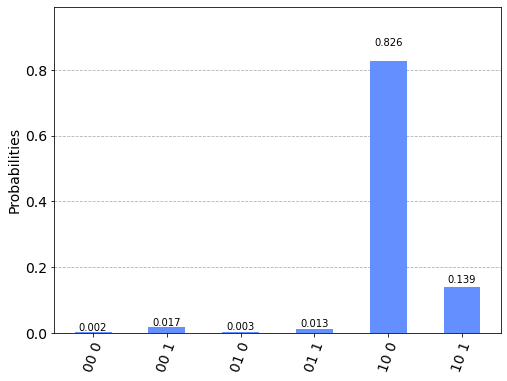

In [ ]:
# Do the experiment
result, circ = run_quantum_circuit(r = 6, t = 3*np.pi)
qsol = approximate_quantum_sol(result,b_num)

print("============================== Final results ==============================\n")
print ('Exact solution = ', csol)
print('Quantum solver solution = ', qsol)
print('Norm of difference = ', LA.norm(qsol- csol),'\n')

plot_histogram(result,figsize = (8,6),bar_labels = True)

In [ ]:
# Draw the quantum circuit
print("============================== Circuit structure ============================== \n")
circ.draw()

============================== Circuit structure ============================== 



»
   ancilla_0: ─────────────────────────────────────────────────────────»
                        ┌───┐                                          »
      regC_0: ──────────┤ H ├─────────────────■────────────────────────»
                        ├───┤                 │                        »
      regC_1: ──────────┤ H ├─────────────────┼───────────────■────────»
                        ├───┤                 │               │        »
      regC_2: ──────────┤ H ├─────────────────┼───────────────┼────────»
                        ├───┤                 │               │        »
      regC_3: ──────────┤ H ├─────────────────┼───────────────┼────────»
              ┌─────────┴───┴─────────┐┌──────┴───────┐┌──────┴───────┐»
      regb_0: ┤0                      ├┤0             ├┤0             ├»
              │  initialize(0,0,-1,0) ││  Hamiltonian ││  Hamiltonian │»
      regb_1: ┤1                      ├┤1             ├┤1             ├»
              └───────────────────────┘└──────────────┘└──────────────┘»
ancilla\_c_0: ═════════════════════════════════════════════════════════»
                                                                       »
   regb\_c_0: ═════════════════════════════════════════════════════════»
                                                                       »
   regb\_c_1: ═════════════════════════════════════════════════════════»
                                                                       »
«                                                       ┌──────────┐»
«   ancilla_0: ─────────────────────────────────────────┤ RY(pi/2) ├»
«                                              ┌───────┐└────┬─────┘»
«      regC_0: ────────────────────────────────┤0      ├─────■──────»
«                                              │       │            »
«      regC_1: ────────────────────────────────┤1      ├─────X──────»
«                                              │  IQFT │     │      »
«      regC_2: ───────■────────────────────────┤2      ├─────┼──────»
«                     │                        │       │     │      »
«      regC_3: ───────┼───────────────■────────┤3      ├─────X──────»
«              ┌──────┴───────┐┌──────┴───────┐└───────┘            »
«      regb_0: ┤0             ├┤0             ├─────────────────────»
«              │  Hamiltonian ││  Hamiltonian │                     »
«      regb_1: ┤1             ├┤1             ├─────────────────────»
«              └──────────────┘└──────────────┘                     »
«ancilla\_c_0: ═════════════════════════════════════════════════════»
«                                                                   »
«   regb\_c_0: ═════════════════════════════════════════════════════»
«                                                                   »
«   regb\_c_1: ═════════════════════════════════════════════════════»
«                                                                   »
«              ┌──────────┐┌──────────┐┌───────────┐   ┌─┐        »
«   ancilla_0: ┤ RY(pi/4) ├┤ RY(pi/8) ├┤ RY(pi/16) ├───┤M├────────»
«              └────┬─────┘└────┬─────┘└─────┬─────┘   └╥┘┌──────┐»
«      regC_0: ─────┼───────────┼────────────┼──────────╫─┤0     ├»
«                   │           │            │          ║ │      │»
«      regC_1: ─────■───────────┼────────────┼───────X──╫─┤1     ├»
«                               │            │       │  ║ │  QFT │»
«      regC_2: ─────────────────■────────────┼───────┼──╫─┤2     ├»
«                                            │       │  ║ │      │»
«      regC_3: ──────────────────────────────■───────X──╫─┤3     ├»
«                                                       ║ └──────┘»
«      regb_0: ─────────────────────────────────────────╫─────────»
«                                                       ║         »
«      regb_1: ─────────────────────────────────────────╫─────────»
«                                                       ║         »
«ancilla\_c_0: ═════════════════════════════════